In [1]:
## import libraries
import os, sys
import yaml
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
%matplotlib inline
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import textwrap

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap
# dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
def compare_mclimate_to_forecast(fc, mclimate):
    ## compare IVT forecast to mclimate
    b_lst = []
    quant_lst = [0.  , 0.75, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ]
    nquantiles = len(quant_lst)
    for i, quant in enumerate(range(nquantiles)):
        bottom = mclimate.ivt.isel(quantile=quant).squeeze() # minimum threshold
        
        if i == 0:
            # only need to see where IVT in the forecast is less than minimum quantile
            b = xr.where(cond=fc.IVT < bottom, x=quant_lst[i], y=np.nan)
            
        elif (i > 0) & (i < nquantiles-1):
            # where IVT in the forecast is greater than current quartile, but less than next quartile
            top = mclimate.ivt.isel(quantile=i+1)
            b = xr.where(cond=(fc.IVT > bottom) & (fc.IVT < top), x=quant_lst[i], y=np.nan)
            
        elif (i == nquantiles-1):
            # where IVT is greater than final quartile
            b = xr.where(cond=(fc.IVT > bottom), x=quant_lst[i], y=np.nan)
    
        b.name = 'ivt'
        
        var_dict = {'ivt_mclimate': (['lat', 'lon'], b.squeeze().values)}
        new_ds = xr.Dataset(var_dict,
                        coords={'lat': (['lat'], b.lat.values),
                                'lon': (['lon'], b.lon.values)})
        
        b_lst.append(new_ds)
            
    ds = xr.merge(b_lst)

    return ds

    

In [4]:
## load all lead times
mon = 11
day = 15
lead = 168

## load mclimate data
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_{0}{1}_*hr-lead.nc'.format(mon, day)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.sortby("step") # sort by step (forecast lead)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sel(step=lead, lon=slice(-179.5, -110.), lat=slice(70., 10.))

## load the reforecast
## testing 162 hr lead from Nov 21, 2013
## TODO write the code so that it chooses the right fname based on lead, day, month, year
fname = path_to_data + 'preprocessed/GEFSv12_reforecast/ivt/20131115_ivt_F147_F168.nc'
forecast = xr.open_dataset(fname)
forecast = forecast.rename({'longitude': 'lon', 'latitude': 'lat', 'ivt': 'IVT'}) # need to rename this to match GEFSv12 Reforecast
forecast = forecast.sel(lon=slice(-179.5, -110.))
forecast = forecast.drop_vars(["ivtu", "ivtv"])
forecast = forecast.isel(step=-1) ### need to fix this so it selects the right time step based on input
forecast = forecast.mean('number') # ensemble mean

ds1 = compare_mclimate_to_forecast(forecast, ds)

/expanse/nfs/cw3e/cwp140/preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_1115_*hr-lead.nc


/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [5]:
## load all lead times
mon = 11
day = 14
lead = 162

## load mclimate data
fname_pattern = path_to_data + 'preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_{0}{1}_*hr-lead.nc'.format(mon, day)
print(fname_pattern)
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim="step", combine='nested')
ds = ds.sortby("step") # sort by step (forecast lead)
ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'}) # need to rename this to match GEFSv12 Reforecast
ds = ds.sel(step=lead, lon=slice(-179.5, -110.), lat=slice(70., 10.))

## load the forecast
## testing 162 hr lead to Nov 21, 2023
fname = path_to_data + '/downloads/GFS_025d/GFS_IVT_2023111406_F162.nc'
forecast2 = xr.open_dataset(fname)
forecast2 = forecast2.rename({'lon_0': 'lon', 'lat_0': 'lat'}) # need to rename this to match GEFSv12 Reforecast
forecast2 = forecast2.assign_coords({"lon": (((forecast2.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
forecast2 = forecast2.sel(lon=slice(-179.5, -110.))
forecast2 = forecast2.drop_vars(["uIVT", "vIVT"])
init_time = pd.to_datetime('2023111406', format="%Y%m%d%H")
valid_time = init_time  + timedelta(hours=162)
forecast2 = forecast2.assign({"valid_time": valid_time, "time": init_time})

ds2 = compare_mclimate_to_forecast(forecast2, ds)

ds_lst = [forecast, forecast2]
fc_lst = [ds1, ds2]

/expanse/nfs/cw3e/cwp140/preprocessed/mclimate/GEFSv12_reforecast_mclimate_ivt_1114_*hr-lead.nc


/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [6]:
# Set up projection
mapcrs = ccrs.Mercator()
# mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = forecast.lat.values
lons = forecast.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+5,5)

ext = [-170., -120., 40., 65.]

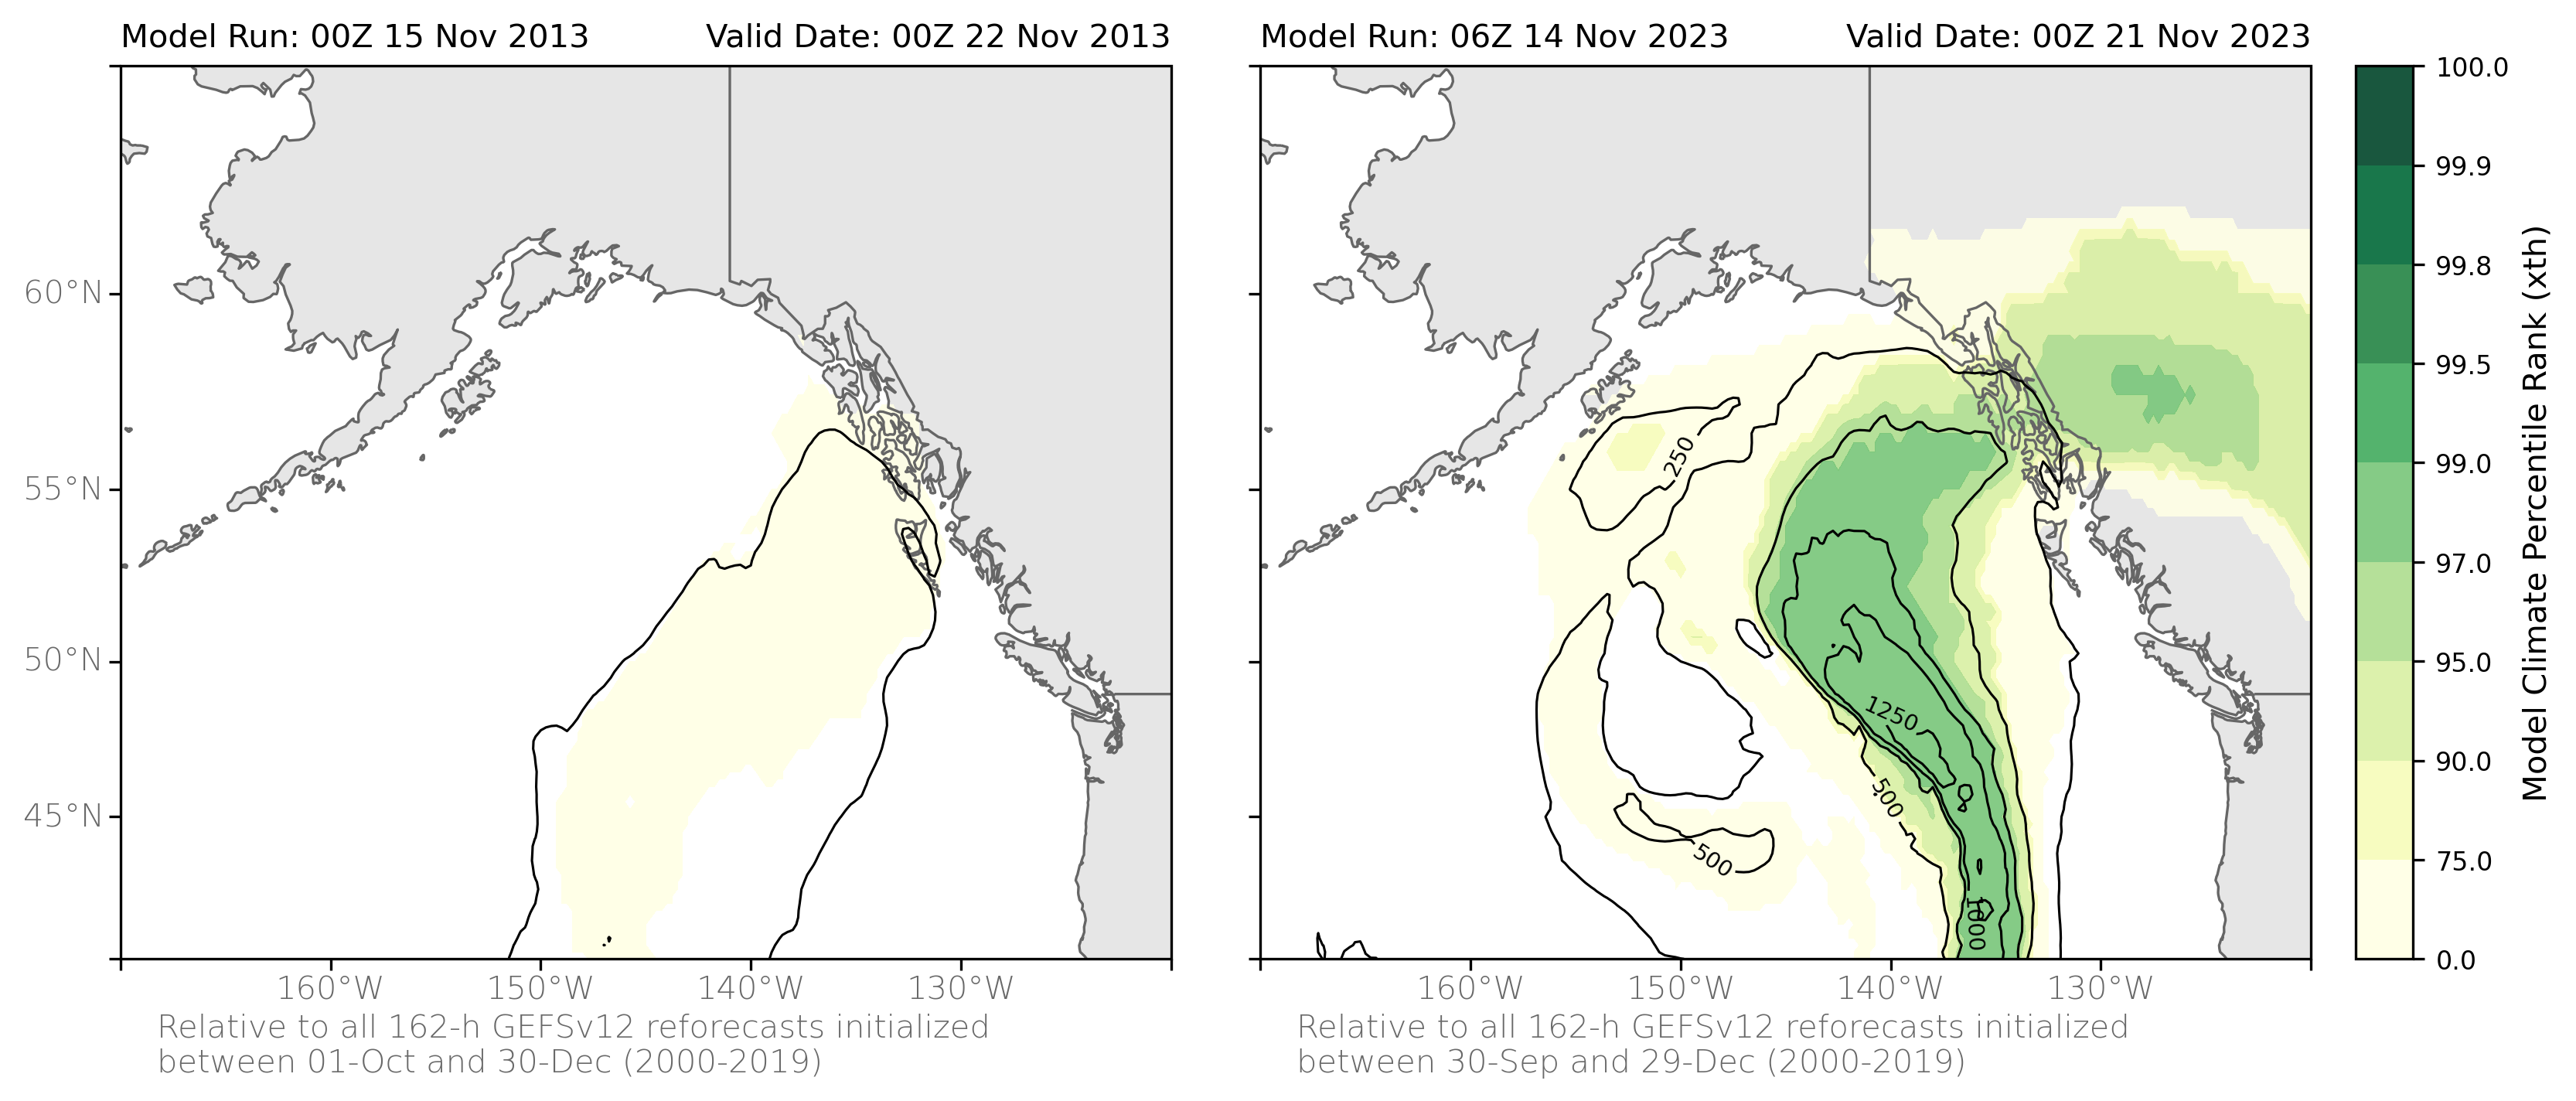

In [7]:
# Create figure
fig = plt.figure(figsize=(13, 5))
fig.dpi = 300
fname = path_to_figs + 'ams_poster_ivt_strength'
fmt = 'png'

nrows = 1
ncols = 3

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 0.05], wspace=0.001, hspace=0.05)
## use gs[rows index, columns index] to access grids

###################
### CLIMATOLOGY ###
###################
leftlats_lst = [True, False]
for i, (fc, ds) in enumerate(zip(fc_lst, ds_lst)):
    ax = fig.add_subplot(gs[0, i], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=True)
    
    # Contour Filled
    data = fc.ivt_mclimate.values*100.
    cmap, norm, bnds = ccmap.cmap('mclimate')
    cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')
    
    # Contour Lines
    clevs = np.arange(250., 2100., 250.)
    cs = ax.contour(ds.lon, ds.lat, ds.IVT, transform=datacrs,
                     levels=clevs, colors='k',
                     linewidths=0.75, linestyles='solid')
    plt.clabel(cs, **kw_clabels)
    
    ts = pd.to_datetime(str(ds.time.values)) 
    init_time = ts.strftime('%HZ %d %b %Y')
    start_date = ts - timedelta(days=45)
    start_date = start_date.strftime('%d-%b')
    end_date = ts + timedelta(days=45)
    end_date = end_date.strftime('%d-%b')
    
    ts = pd.to_datetime(str(ds.valid_time.values)) 
    valid_time = ts.strftime('%HZ %d %b %Y')
    
    ax.set_title('Model Run: {0}'.format(init_time), loc='left', fontsize=10)
    ax.set_title('Valid Date: {0}'.format(valid_time), loc='right', fontsize=10)

    
    txt = 'Relative to all 162-h GEFSv12 reforecasts initialized between {0} and {1} (2000-2019)'.format(start_date, end_date)
    ann_ax = fig.add_subplot(gs[-1, i])
    ann_ax.axis('off')
    ann_ax.annotate(textwrap.fill(txt, 60), # this is the text
               (0, 0.), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(25,-35), # distance from text to points (x,y)
                ha='left', # horizontal alignment can be left, right or center
                **kw_ticklabels)


# Add color bar
cbax = plt.subplot(gs[0,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()